# EIS metadata validation script
Used to validate Planon output with spreadsheet input

## 1. Data import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Read data. There are two datasets: Planon and Master. The latter is the EIS data nomencalture that was created. Master is made up of two subsets: loggers and meters. Loggers are sometimes called controllers and meters are sometimes called sensors. In rare cases meters or sensors are also called channels.

In [3]:
planon=pd.read_excel('EIS Assets v2.xlsx',index_col = 'Code')
#master_loggerscontrollers_old = pd.read_csv('LoggersControllers.csv', index_col = 'Asset Code')
#master_meterssensors_old = pd.read_csv('MetersSensors.csv', encoding = 'macroman', index_col = 'Asset Code')
master='MASTER PlanonLoggersAndMeters 17 10 16.xlsx'
master_loggerscontrollers=pd.read_excel(master,sheetname='Loggers Controllers', index_col = 'Asset Code')
master_meterssensors=pd.read_excel(master,sheetname='Meters Sensors', encoding = 'macroman', index_col = 'Asset Code')
planon['Code']=planon.index
master_loggerscontrollers['Code']=master_loggerscontrollers.index
master_meterssensors['Code']=master_meterssensors.index

In [4]:
set(master_meterssensors['Classification Group'])

{'Energy meter', 'Energy sensor'}

In [5]:
set(master_loggerscontrollers['Classification Group'])

{nan, 'BMS controller', 'Data logger'}

In [6]:
new_index=[]
for i in master_meterssensors.index:
    if '/' not in i:
        new_index.append(i[:i.find('-')+1]+i[i.find('-')+1:].replace('-','/'))
    else:
        new_index.append(i)

In [7]:
master_meterssensors.index=new_index
master_meterssensors['Code']=master_meterssensors.index

In [8]:
new_index=[]
for i in master_meterssensors.index:
    logger=i[:i.find('/')]
    if master_loggerscontrollers.loc[logger]['Classification Group']=='BMS controller':
        meter=i[i.find('/')+1:]
        if meter[0] not in {'N','n','o','i'}:
            new_index.append(i)   
    else:
        new_index.append(i)   

In [9]:
len(master_meterssensors)

30597

In [10]:
master_meterssensors=master_meterssensors.loc[new_index]

In [11]:
len(master_meterssensors)

29218

In [12]:
master_meterssensors.to_csv('meterssensors.csv')

In [13]:
master_loggerscontrollers.to_csv('loggerscontrollers.csv')

Unify index, caps everything and strip of trailing spaces.

In [14]:
planon.index=[str(i).strip() for i in planon.index]
master_loggerscontrollers.index=[str(i).strip() for i in master_loggerscontrollers.index]
master_meterssensors.index=[str(i).strip() for i in master_meterssensors.index]

Drop duplicates (shouldn't be any)

In [15]:
planon.drop_duplicates(inplace=True)
master_loggerscontrollers.drop_duplicates(inplace=True)
master_meterssensors.drop_duplicates(inplace=True)

Split Planon import into loggers and meters  
Drop duplicates (shouldn't be any)

In [16]:
# Split the Planon file into 2, one for loggers & controllers, and one for meters & sensors.
planon_loggerscontrollers = planon.loc[(planon['Classification Group'] == 'EN.EN4 BMS Controller') | (planon['Classification Group'] == 'EN.EN1 Data Logger')]
planon_meterssensors = planon.loc[(planon['Classification Group'] == 'EN.EN2 Energy Meter') | (planon['Classification Group'] == 'EN.EN3 Energy Sensor')]
planon_loggerscontrollers.drop_duplicates(inplace=True)
planon_meterssensors.drop_duplicates(inplace=True)

C:\Anaconda2\envs\python3\lib\site-packages\pandas\util\decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


Index unique? show number of duplicates in index

In [17]:
len(planon_loggerscontrollers.index[planon_loggerscontrollers.index.duplicated()])

0

In [18]:
len(planon_meterssensors.index[planon_meterssensors.index.duplicated()])

3256

Meters are not unique. This is becasue of the spaces served. This is ok for now, we will deal with duplicates at the comparison stage. Same is true for loggers - in the unlikely event that there are duplicates in the future.

In [19]:
planon_meterssensors.head(3)

,BuildingNo.,Building,Locations.Space.Space number,Space Name,Additional Location Info,Description,Classification Group,Record,HVAC Ref,Element Description,...,Logger SIM,Meter Pulse Value,Meter Units,Meter Capacity,Network Point ID,Tenant Meter.Name,Fiscal Meter.Name,EIS Space.Space number,Utility Type.Name,Code
AP000-L01/M001,AP000,Alexandra Park,NaN,NaN,NaN,NaN,EN.EN2 Energy Meter,NaN,NaN,NaN,...,NaN,NaN,kWh,NaN,NaN,No,No,NaN,NaN,AP000-L01/M001
AP000-L02/M001,AP000,Alexandra Park,NaN,NaN,NaN,Graduate House 1-11,EN.EN2 Energy Meter,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,No,No,NaN,NaN,AP000-L02/M001
AP000-L02/M002,AP000,Alexandra Park,NaN,NaN,NaN,Alex Park Main,EN.EN2 Energy Meter,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,No,No,NaN,NaN,AP000-L02/M002


## 2. Validation

Create list of all buildings present in Planon export. These are buildings to check the data against from Master.

In [20]:
buildings=set(planon_meterssensors['BuildingNo.'])
buildings

{'AP000',
 'AP001',
 'AP009',
 'AP010',
 'AP011',
 'AP057',
 'AP080',
 'AP081',
 'EX001',
 'MC000',
 'MC001',
 'MC003',
 'MC007',
 'MC008',
 'MC010',
 'MC011',
 'MC013',
 'MC014',
 'MC029',
 'MC030',
 'MC031',
 'MC032',
 'MC033',
 'MC043',
 'MC044',
 'MC045',
 'MC046',
 'MC047',
 'MC048',
 'MC050',
 'MC051',
 'MC053',
 'MC055',
 'MC061',
 'MC062',
 'MC063',
 'MC064',
 'MC065',
 'MC066',
 'MC067',
 'MC068',
 'MC069',
 'MC070',
 'MC071',
 'MC072',
 'MC075',
 'MC076',
 'MC077',
 'MC078',
 'MC083',
 'MC095',
 'MC099',
 'MC102',
 'MC103',
 'MC125',
 'MC126',
 'MC128',
 'MC129',
 'MC131',
 'MC134',
 'MC138',
 'MC139',
 'MC140',
 'MC141',
 'MC171',
 'MC181',
 'MC197',
 'MC198',
 'MC199',
 'MC200',
 'MC202',
 'MC203',
 'MC204',
 'MC207',
 'MC208',
 'MC210',
 'MC211',
 'OC004',
 'OC005',
 'OC006'}

In [21]:
len(buildings)

80

### 2.1. Meters

Create dataframe slice for validation from `master_meterssensors` where the only the buildings located in `buildings` are contained. Save this new slice into `master_meterssensors_for_validation`. This is done by creating sub-slices of the dataframe for each building, then concatenating them all together.

In [22]:
master_meterssensors_for_validation = \
    pd.concat([master_meterssensors.loc[master_meterssensors['Building Code'] == building] \
           for building in buildings])
master_meterssensors_for_validation.head(2)

,Logger Asset Code,Description,Make,Model,Meter Units,Meter Pulse Value,Classification Group,Logger Channel,Utility Type,??,...,Building Name,Space,Additional Location Info,Tenant meter,Fiscal meter,Parent meter,Child meters,Communications type,Electrical panel ID,Code
MC008-L99/M302,MC008-L99,CEH Remote Workshops,NaN,NaN,NaN,NaN,Energy meter,NaN,Natural Gas,NaN,...,LEC Remote Workshops,MC008 A0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,MC008-L99/M302
MC008-L01/M001,MC008-L01,LEC Workshop,Sensus,HRI-A3,m3,0.001,Energy meter,1,Water,NaN,...,LEC Remote Workshops,NaN,A19,1.0,0.0,NaN,NaN,NaN,NaN,MC008-L01/M001


In [23]:
#alternative method
master_meterssensors_for_validation2 = \
    master_meterssensors[master_meterssensors['Building Code'].isin(buildings)]
master_meterssensors_for_validation2.head(2)

,Logger Asset Code,Description,Make,Model,Meter Units,Meter Pulse Value,Classification Group,Logger Channel,Utility Type,??,...,Building Name,Space,Additional Location Info,Tenant meter,Fiscal meter,Parent meter,Child meters,Communications type,Electrical panel ID,Code
MC046-L19/M001,MC046-L19,Meter 1,NaN,NaN,NaN,NaN,Energy meter,DI1,NaN,NaN,...,Bowland Main,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,MC046-L19/M001
MC046-L19/M002,MC046-L19,Meter 2,NaN,NaN,NaN,NaN,Energy meter,DI2,NaN,NaN,...,Bowland Main,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,MC046-L19/M002


Planon sensors are not unique because of the spaces served convention in the two data architectures. The Planon architecture devotes a new line for each space served - hence the not unique index. The Master architecture lists all the spaces only once, as a list, therefore it has a unique index. We will need to take this into account and create matching dataframe out of planon for comparison, with a unique index.

In [24]:
len(master_meterssensors_for_validation)

29188

In [25]:
len(planon_meterssensors)-len(planon_meterssensors.index[planon_meterssensors.index.duplicated()])

28824

Sort datasets after index for easier comparison.

In [26]:
master_meterssensors_for_validation.sort_index(inplace=True)
planon_meterssensors.sort_index(inplace=True)

C:\Anaconda2\envs\python3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


#### 2.1.1 Slicing of meters to  only certain columns of comparison

In [27]:
planon_meterssensors.T

,AP000-L01/M001,AP000-L02/M001,AP000-L02/M002,AP000-L03/M001,AP000-L03/M002,AP001-L01/M001,AP001-L01/M002,AP001-L01/M003,AP001-L01/M004,AP001-L01/M005,...,OC006-B01/W4,OC006-B01/W5,OC006-B01/Y1,OC006-B01/Y2,OC006-B01/Y3,OC006-B01/Y4,OC006-B01/Y5,OC006-B01/Y6,OC006-B01/Z1,OC006-B01/Z2
BuildingNo.,AP000,AP000,AP000,AP000,AP000,AP001,AP001,AP001,AP001,AP001,...,OC006,OC006,OC006,OC006,OC006,OC006,OC006,OC006,OC006,OC006
Building,Alexandra Park,Alexandra Park,Alexandra Park,Alexandra Park,Alexandra Park,"House 01 - Bassenthwaite, Graduate College","House 01 - Bassenthwaite, Graduate College","House 01 - Bassenthwaite, Graduate College","House 01 - Bassenthwaite, Graduate College","House 01 - Bassenthwaite, Graduate College",...,"Chancellor's Wharf, Kent House","Chancellor's Wharf, Kent House","Chancellor's Wharf, Kent House","Chancellor's Wharf, Kent House","Chancellor's Wharf, Kent House","Chancellor's Wharf, Kent House","Chancellor's Wharf, Kent House","Chancellor's Wharf, Kent House","Chancellor's Wharf, Kent House","Chancellor's Wharf, Kent House"
Locations.Space.Space number,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Space Name,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Additional Location Info,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,NaN,Graduate House 1-11,Alex Park Main,NaN,NaN,NaN,Bar Cellar,Bar Ground,Services Room,Bar Water,...,ShuntPumpRotate,Manual Shunt pump changeover,Outside air temperature,Immersion Sensor,Thermistor TBTC,Room temperature,Thermistor TBTI,4DIX V,Heating Boilers,DHWS Immersion
Classification Group,EN.EN2 Energy Meter,EN.EN2 Energy Meter,EN.EN2 Energy Meter,EN.EN2 Energy Meter,EN.EN2 Energy Meter,EN.EN2 Energy Meter,EN.EN2 Energy Meter,EN.EN2 Energy Meter,EN.EN2 Energy Meter,EN.EN2 Energy Meter,...,EN.EN3 Energy Sensor,EN.EN3 Energy Sensor,EN.EN3 Energy Sensor,EN.EN3 Energy Sensor,EN.EN3 Energy Sensor,EN.EN3 Energy Sensor,EN.EN3 Energy Sensor,EN.EN3 Energy Sensor,EN.EN3 Energy Sensor,EN.EN3 Energy Sensor
Record,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HVAC Ref,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Element Description,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
master_meterssensors_for_validation.T

,AP000-L01/M001,AP000-L02/M001,AP000-L02/M002,AP000-L03/M001,AP000-L03/M002,AP000-L99/M303,AP000-L99/M308,AP001-L01/M001,AP001-L01/M002,AP001-L01/M003,...,OC006-B01/Y1,OC006-B01/Y2,OC006-B01/Y3,OC006-B01/Y4,OC006-B01/Y5,OC006-B01/Y6,OC006-B01/Z1,OC006-B01/Z2,OC006-L99/M200,OC006-L99/M503
Logger Asset Code,AP000-L01,AP000-L02,AP000-L02,AP000-L03,AP000-L03,AP000-L99,AP000-L99,AP001-L01,AP001-L01,AP001-L01,...,OC006-B01,OC006-B01,OC006-B01,OC006-B01,OC006-B01,OC006-B01,OC006-B01,OC006-B01,OC006-L99,OC006-L99
Description,NaN,Graduate House 1-11,Alex Park Main,NaN,NaN,Alex Park LU,Alex Park UPP,NaN,Bar Cellar,Bar Ground,...,Outside air temperature,Immersion Sensor,Thermistor TBTC,Room temperature,Thermistor TBTI,4DIX V,Heating Boilers,DHWS Immersion,Kent House,Kent House
Make,Carlo Gavazzi,Actaris,Delta,,,NaN,NaN,,Elster,Landis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Model,EM24,Delta G,D35,,,NaN,NaN,,A1100,E1100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Meter Units,kWh,NaN,NaN,NaN,NaN,NaN,NaN,m3,kWh,kWh,...,Degrees Celsius,NaN,NaN,Degrees Celsius,Degrees Celsius,NaN,NaN,NaN,kWh,NaN
Meter Pulse Value,1,NaN,NaN,NaN,NaN,NaN,NaN,0.001,0.001,0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Classification Group,Energy meter,Energy meter,Energy meter,Energy meter,Energy meter,Energy meter,Energy meter,Energy meter,Energy meter,Energy meter,...,Energy sensor,Energy sensor,Energy sensor,Energy sensor,Energy sensor,Energy sensor,Energy sensor,Energy sensor,Energy meter,Energy meter
Logger Channel,1,1,2,1,2,NaN,NaN,1,2,3,...,Y1,Y2,Y3,Y4,Y5,Y6,Z1,Z2,NaN,NaN
Utility Type,Electricity,Natural Gas,Natural Gas,Water,Water,Natural Gas,Natural Gas,Water,Electricity,Electricity,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electricity,Water
??,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Create dictionary that maps Planon column names onto Master.  
  
From Nicola:  
- Code (Asset Code)  
- Description
- EIS ID (Channel)
- Utility Type
- Fiscal Meter
- Tenant Meter

`Building code` and `Building name` are implicitly included. `Logger Serial Number`, `IP` or `MAC` would be essential to include, as well as `Make` and `Model`. `Additional Location Info` is not essnetial but would be useful to have. Locations (`Locations.Space.Space number` and `Space Name`) are included in the Planon export - but this is their only viable data source, therefore are not validated against.

In [29]:
#Planon:Master
meters_match_dict={
      "BuildingNo.":"Building Code",
      "Building":"Building Name",
      "Description":"Description",
      "EIS ID":"Logger Channel",
      "Tenant Meter.Name":"Tenant meter",
      "Fiscal Meter.Name":"Fiscal meter",
      "Code":"Code"
      }

Filter both dataframes based on these new columns. Then remove duplicates. Currently, this leads to loss of information of spaces served, but also a unique index for the Planon dataframe, therefore bringing the dataframes closer to each other. When including spaces explicitly in the comparison (if we want to - or just trust the  Planon space mapping), this needs to be modified.

In [30]:
master_meterssensors_for_validation_filtered=master_meterssensors_for_validation[list(meters_match_dict.values())]
planon_meterssensors_filtered=planon_meterssensors[list(meters_match_dict.keys())]

In [31]:
master_meterssensors_for_validation_filtered.head(2)

,Logger Channel,Building Name,Code,Building Code,Fiscal meter,Description,Tenant meter
AP000-L01/M001,1,Alexandra Park,AP000-L01/M001,AP000,0.0,NaN,0.0
AP000-L02/M001,1,Alexandra Park,AP000-L02/M001,AP000,0.0,Graduate House 1-11,0.0


In [32]:
planon_meterssensors_filtered.head(2)

,EIS ID,Building,Code,BuildingNo.,Fiscal Meter.Name,Description,Tenant Meter.Name
AP000-L01/M001,1,Alexandra Park,AP000-L01/M001,AP000,No,NaN,No
AP000-L02/M001,1,Alexandra Park,AP000-L02/M001,AP000,No,Graduate House 1-11,No


Unify headers, drop duplicates (bear the mind the spaces argument, this where it needs to be brought back in in the future!).

In [33]:
planon_meterssensors_filtered.columns=[meters_match_dict[i] for i in planon_meterssensors_filtered]

In [34]:
planon_meterssensors_filtered.drop_duplicates(inplace=True)
master_meterssensors_for_validation_filtered.drop_duplicates(inplace=True)

C:\Anaconda2\envs\python3\lib\site-packages\pandas\util\decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


In [35]:
planon_meterssensors_filtered.head(2)

,Logger Channel,Building Name,Code,Building Code,Fiscal meter,Description,Tenant meter
AP000-L01/M001,1,Alexandra Park,AP000-L01/M001,AP000,No,NaN,No
AP000-L02/M001,1,Alexandra Park,AP000-L02/M001,AP000,No,Graduate House 1-11,No


Fiscal/Tenant meter name needs fixing from Yes/No and 1/0.

In [36]:
planon_meterssensors_filtered['Fiscal meter']=planon_meterssensors_filtered['Fiscal meter'].isin(['Yes'])
planon_meterssensors_filtered['Tenant meter']=planon_meterssensors_filtered['Tenant meter'].isin(['Yes'])
master_meterssensors_for_validation_filtered['Fiscal meter']=master_meterssensors_for_validation_filtered['Fiscal meter'].isin([1])
master_meterssensors_for_validation_filtered['Tenant meter']=master_meterssensors_for_validation_filtered['Tenant meter'].isin([1])

C:\Anaconda2\envs\python3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Anaconda2\envs\python3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Anaconda2\envs\python3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [37]:
master_meterssensors_for_validation_filtered.head(2)

,Logger Channel,Building Name,Code,Building Code,Fiscal meter,Description,Tenant meter
AP000-L01/M001,1,Alexandra Park,AP000-L01/M001,AP000,False,NaN,False
AP000-L02/M001,1,Alexandra Park,AP000-L02/M001,AP000,False,Graduate House 1-11,False


In [38]:
planon_meterssensors_filtered.head(2)

,Logger Channel,Building Name,Code,Building Code,Fiscal meter,Description,Tenant meter
AP000-L01/M001,1,Alexandra Park,AP000-L01/M001,AP000,False,NaN,False
AP000-L02/M001,1,Alexandra Park,AP000-L02/M001,AP000,False,Graduate House 1-11,False


Cross-check missing meters

In [39]:
a=np.sort(list(set(planon_meterssensors_filtered.index)))
b=np.sort(list(set(master_meterssensors_for_validation_filtered.index)))
meterssensors_not_in_planon=[]
for i in b:
    if i not in a:
        print(i+',',end=" "),
        meterssensors_not_in_planon.append(i)
print('\n\nMeters in Master, but not in Planon:',
      len(meterssensors_not_in_planon),'/',len(b),':',
      round(len(meterssensors_not_in_planon)/len(b)*100,3),'%')

AP000-L99/M303, AP000-L99/M308, AP080-L79/M001, AP080-L80/M001, AP080-L81/M001, MC000-L99/M201, MC000-L99/M202, MC000-L99/M203, MC000-L99/M506, MC001-L82/M972, MC001-L82/M973, MC001-L82/M974, MC001-L82/M975, MC001-L82/M976, MC001-L99/M100, MC001-L99/M222, MC001-L99/M224, MC001-L99/M306, MC001-L99/M508, MC003-L99/M207, MC003-L99/M304, MC003-L99/M509, MC007-L99/M211, MC007-L99/M511, MC008-L82/M916, MC008-L99/M302, MC010-L82/M745, MC010-L82/M746, MC010-L82/M747, MC010-L82/M748, MC010-L82/M749, MC010-L82/M750, MC010-L82/M751, MC010-L82/M752, MC010-L82/M753, MC010-L82/M754, MC010-L82/M755, MC010-L82/M756, MC010-L82/M757, MC010-L82/M758, MC010-L82/M759, MC010-L82/M760, MC010-L82/M761, MC010-L82/M762, MC010-L82/M763, MC010-L82/M764, MC010-L82/M765, MC010-L82/M766, MC010-L82/M767, MC010-L82/M768, MC010-L82/M769, MC010-L82/M770, MC010-L82/M771, MC010-L82/M772, MC011-L82/M953, MC011-L82/M954, MC032-L82/M773, MC032-L82/M774, MC033-L82/M898, MC033-L82/M899, MC044-L82/M794, MC044-L82/M795, MC044-L8

In [40]:
(set([i[:5] for i in meterssensors_not_in_planon]))

{'AP000',
 'AP080',
 'MC000',
 'MC001',
 'MC003',
 'MC007',
 'MC008',
 'MC010',
 'MC011',
 'MC032',
 'MC033',
 'MC044',
 'MC045',
 'MC046',
 'MC047',
 'MC061',
 'MC063',
 'MC065',
 'MC070',
 'MC071',
 'MC072',
 'MC075',
 'MC102',
 'MC103',
 'MC125',
 'MC126',
 'MC128',
 'MC129',
 'MC131',
 'MC197',
 'MC200',
 'MC204',
 'MC207',
 'MC210',
 'MC211',
 'OC004',
 'OC005',
 'OC006'}

In [41]:
a=np.sort(list(set(planon_meterssensors_filtered.index)))
b=np.sort(list(set(master_meterssensors_for_validation_filtered.index)))
meterssensors_not_in_master=[]
for i in a:
    if i not in b:
        print(i+',',end=" "),
        meterssensors_not_in_master.append(i)
print('\n\nMeters in Planon, not in Master:',
      len(meterssensors_not_in_master),'/',len(a),':',
      round(len(meterssensors_not_in_master)/len(a)*100,3),'%')



Meters in Planon, not in Master: 0 / 28824 : 0.0 %


In [42]:
len(set([i for i in meterssensors_not_in_master]))

0

In [43]:
set([i[:9] for i in meterssensors_not_in_master])

set()

In [44]:
set([i[:5] for i in meterssensors_not_in_master])

set()

Check for duplicates in index, but not duplicates over the entire row

In [45]:
print(len(planon_meterssensors_filtered.index))
print(len(set(planon_meterssensors_filtered.index)))
print(len(master_meterssensors_for_validation_filtered.index))
print(len(set(master_meterssensors_for_validation_filtered.index)))

28824
28824
29188
29188


In [46]:
master_meterssensors_for_validation_filtered[master_meterssensors_for_validation_filtered.index.duplicated()]

,Logger Channel,Building Name,Code,Building Code,Fiscal meter,Description,Tenant meter


The duplicates are the `nan`s. Remove these for now. Could revisit later to do an index-less comparison, only over row contents.

In [47]:
good_index=[i for i in master_meterssensors_for_validation_filtered.index if str(i).lower().strip()!='nan']
master_meterssensors_for_validation_filtered=master_meterssensors_for_validation_filtered.loc[good_index]
master_meterssensors_for_validation_filtered.drop_duplicates(inplace=True)

In [48]:
len(planon_meterssensors_filtered)

28824

In [49]:
len(master_meterssensors_for_validation_filtered)

29188

Do comparison only on common indices. Need to revisit and identify the cause missing meters, both ways (5 Planon->Meters and 30 Meters->Planon in this example).

In [50]:
comon_index=list(set(master_meterssensors_for_validation_filtered.index).intersection(set(planon_meterssensors_filtered.index)))

In [51]:
len(comon_index)

28824

In [52]:
master_meterssensors_for_validation_intersected=master_meterssensors_for_validation_filtered.loc[comon_index].sort_index()
planon_meterssensors_intersected=planon_meterssensors_filtered.loc[comon_index].sort_index()

In [53]:
len(master_meterssensors_for_validation_intersected)

28824

In [54]:
len(planon_meterssensors_intersected)

28824

Still have duplicate indices. For now we just drop and keep the first.

In [55]:
master_meterssensors_for_validation_intersected = master_meterssensors_for_validation_intersected[~master_meterssensors_for_validation_intersected.index.duplicated(keep='first')]

In [56]:
master_meterssensors_for_validation_intersected.head(2)

,Logger Channel,Building Name,Code,Building Code,Fiscal meter,Description,Tenant meter
AP000-L01/M001,1,Alexandra Park,AP000-L01/M001,AP000,False,NaN,False
AP000-L02/M001,1,Alexandra Park,AP000-L02/M001,AP000,False,Graduate House 1-11,False


In [57]:
planon_meterssensors_intersected.head(2)

,Logger Channel,Building Name,Code,Building Code,Fiscal meter,Description,Tenant meter
AP000-L01/M001,1,Alexandra Park,AP000-L01/M001,AP000,False,NaN,False
AP000-L02/M001,1,Alexandra Park,AP000-L02/M001,AP000,False,Graduate House 1-11,False


#### 2.1.2. Primitive comparison

In [58]:
planon_meterssensors_intersected==master_meterssensors_for_validation_intersected

,Logger Channel,Building Name,Code,Building Code,Fiscal meter,Description,Tenant meter
AP000-L01/M001,True,True,True,True,True,False,True
AP000-L02/M001,True,True,True,True,True,True,True
AP000-L02/M002,True,True,True,True,True,True,True
AP000-L03/M001,True,True,True,True,True,False,True
AP000-L03/M002,True,True,True,True,True,False,True
AP001-L01/M001,True,False,True,True,True,False,True
AP001-L01/M002,True,False,True,True,True,False,True
AP001-L01/M003,True,False,True,True,True,False,True
AP001-L01/M004,True,False,True,True,True,False,True
AP001-L01/M005,True,False,True,True,True,True,True


In [59]:
np.all(planon_meterssensors_intersected==master_meterssensors_for_validation_intersected)

False

#### 2.1.3. Horizontal comparison

Number of cells matching

In [60]:
(planon_meterssensors_intersected==master_meterssensors_for_validation_intersected).sum()

Logger Channel    28824
Building Name     28295
Code              28824
Building Code     28824
Fiscal meter      28824
Description       27435
Tenant meter      28824
dtype: int64

Percentage matching

In [61]:
(planon_meterssensors_intersected==master_meterssensors_for_validation_intersected).sum()/\
len(planon_meterssensors_intersected)*100

Logger Channel    100.000000
Building Name      98.164724
Code              100.000000
Building Code     100.000000
Fiscal meter      100.000000
Description        95.181099
Tenant meter      100.000000
dtype: float64

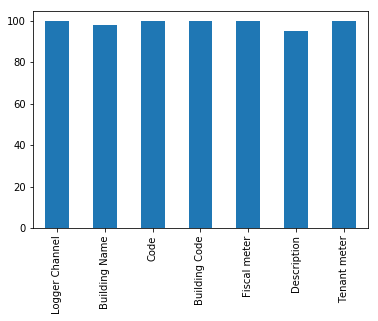

In [62]:
((planon_meterssensors_intersected==master_meterssensors_for_validation_intersected).sum()/\
len(planon_meterssensors_intersected)*100).plot(kind='bar')

#### 2.1.4. Vertical comparison

In [63]:
df=pd.DataFrame((planon_meterssensors_intersected.T==master_meterssensors_for_validation_intersected.T).sum())
df

,0
AP000-L01/M001,6
AP000-L02/M001,7
AP000-L02/M002,7
AP000-L03/M001,6
AP000-L03/M002,6
AP001-L01/M001,5
AP001-L01/M002,5
AP001-L01/M003,5
AP001-L01/M004,5
AP001-L01/M005,6


In [64]:
df=pd.DataFrame((planon_meterssensors_intersected.T==master_meterssensors_for_validation_intersected.T).sum()/\
len(planon_meterssensors_intersected.T)*100)
df[df[0]<100]

,0
AP000-L01/M001,85.714286
AP000-L03/M001,85.714286
AP000-L03/M002,85.714286
AP001-L01/M001,71.428571
AP001-L01/M002,71.428571
AP001-L01/M003,71.428571
AP001-L01/M004,71.428571
AP001-L01/M005,85.714286
AP001-L01/M006,85.714286
AP009-L01/M001,85.714286


#### 2.1.5. Smart(er) comparison

Not all of the dataframe matches. Let us do some basic string formatting, maybe that helps.

In [65]:
sum(planon_meterssensors_intersected['Description']!=master_meterssensors_for_validation_intersected['Description'])

1389

In [66]:
planon_meterssensors_intersected['Description']=[str(s).lower().strip()\
        .replace('  ',' ').replace('   ',' ').replace('nan','')\
        for s in planon_meterssensors_intersected['Description'].values]
master_meterssensors_for_validation_intersected['Description']=[str(s).lower().strip()\
        .replace('  ',' ').replace('   ',' ').replace('nan','')\
        for s in master_meterssensors_for_validation_intersected['Description'].values]

In [67]:
sum(planon_meterssensors_intersected['Description']!=master_meterssensors_for_validation_intersected['Description'])

0

Some errors fixed, some left. Let's see which ones. These are either:  
- Wrong duplicate dropped
- Input human erros in the description.
- Actual erros somewhere in the indexing.

In [68]:
for i in planon_meterssensors_intersected[planon_meterssensors_intersected['Description']!=master_meterssensors_for_validation_intersected['Description']].index:
    print(i,'\t\tPlanon:',planon_meterssensors_intersected.loc[i]['Description'],'\t\tMaster:',master_meterssensors_for_validation_intersected.loc[i]['Description'])

Let us repeat the exercise for `Logger Channel`. Cross-validate, flag as highly likely error where both mismatch.

In [69]:
sum(planon_meterssensors_intersected['Logger Channel']!=master_meterssensors_for_validation_intersected['Logger Channel'])

0

In [70]:
planon_meterssensors_intersected['Logger Channel']=[str(s).lower().strip().replace('  ',' ').replace('   ',' ') for s in planon_meterssensors_intersected['Logger Channel'].values]
master_meterssensors_for_validation_intersected['Logger Channel']=[str(s).lower().strip().replace('  ',' ').replace('   ',' ') for s in master_meterssensors_for_validation_intersected['Logger Channel'].values]

In [71]:
sum(planon_meterssensors_intersected['Logger Channel']!=master_meterssensors_for_validation_intersected['Logger Channel'])

0

All errors fixed on logger channels.

In [72]:
for i in planon_meterssensors_intersected[planon_meterssensors_intersected['Logger Channel']!=master_meterssensors_for_validation_intersected['Logger Channel']].index:
    print(i,'\t\tPlanon:',planon_meterssensors_intersected.loc[i]['Logger Channel'],'\t\tMaster:',master_meterssensors_for_validation_intersected.loc[i]['Logger Channel'])

New error percentage:

In [73]:
(planon_meterssensors_intersected!=master_meterssensors_for_validation_intersected).sum()/\
len(planon_meterssensors_intersected)*100

Logger Channel    0.000000
Building Name     1.835276
Code              0.000000
Building Code     0.000000
Fiscal meter      0.000000
Description       0.000000
Tenant meter      0.000000
dtype: float64

### 2.2. Loggers

In [74]:
buildings=set(planon_loggerscontrollers['BuildingNo.'])
buildings

{'AP000',
 'AP001',
 'AP009',
 'AP010',
 'AP011',
 'AP057',
 'AP080',
 'AP081',
 'EX000',
 'EX001',
 'EX005',
 'FH000',
 'FH002',
 'FH003',
 'FH008',
 'FH012',
 'MC000',
 'MC001',
 'MC002',
 'MC003',
 'MC007',
 'MC008',
 'MC010',
 'MC011',
 'MC013',
 'MC014',
 'MC029',
 'MC030',
 'MC031',
 'MC032',
 'MC033',
 'MC042',
 'MC043',
 'MC044',
 'MC045',
 'MC046',
 'MC047',
 'MC048',
 'MC050',
 'MC051',
 'MC053',
 'MC055',
 'MC060',
 'MC061',
 'MC062',
 'MC063',
 'MC064',
 'MC065',
 'MC066',
 'MC067',
 'MC068',
 'MC069',
 'MC070',
 'MC071',
 'MC072',
 'MC075',
 'MC076',
 'MC077',
 'MC078',
 'MC083',
 'MC095',
 'MC099',
 'MC102',
 'MC103',
 'MC125',
 'MC126',
 'MC128',
 'MC129',
 'MC131',
 'MC134',
 'MC138',
 'MC139',
 'MC140',
 'MC141',
 'MC171',
 'MC181',
 'MC197',
 'MC198',
 'MC199',
 'MC200',
 'MC202',
 'MC203',
 'MC204',
 'MC207',
 'MC210',
 'MC211',
 'OC001',
 'OC003',
 'OC004',
 'OC005',
 'OC006',
 'OC007',
 'OC008',
 'OC011',
 'OC012'}

In [75]:
master_loggerscontrollers_for_validation = \
    pd.concat([master_loggerscontrollers.loc[master_loggerscontrollers['Building Code'] == building] \
           for building in buildings])
master_loggerscontrollers_for_validation.head(2)

,Building Code,Building Name,Space,Description,Classification Group,Make,Model,Logger Serial Number,Logger Mac Address,Logger Ip Address,Logger Modem Serial Number,Logger Sim,Network Point Id,Logger Upstream Comms Target,Additional Location Info,Code
AP081-L01,AP081,Barker House Farm,A64,Data logger: Barker House Farm,Data logger,Enercom,Multilog G2,050157C09600,00-50-C2-2C-3D-17,10.23.9.41,NaN,NaN,NaN,NaN,Plant Room,AP081-L01
MC207-L01,MC207,HR Building,A35,Data logger: HR Building,Data logger,Enercom,Multilog G2,0502285A8700,00-50-C2-2C-3F-3B,10.23.10.106,NaN,NaN,NaN,NaN,HR Building Plant Room,MC207-L01


In [76]:
len(master_loggerscontrollers_for_validation)

378

In [77]:
len(planon_loggerscontrollers)-len(planon_loggerscontrollers.index[planon_loggerscontrollers.index.duplicated()])

359

In [78]:
master_loggerscontrollers_for_validation.sort_index(inplace=True)
planon_loggerscontrollers.sort_index(inplace=True)

C:\Anaconda2\envs\python3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [79]:
planon_loggerscontrollers.T

,AP000-L01,AP000-L02,AP000-L03,AP000-L99,AP001-L01,AP009-L01,AP010-L01,AP011-L01,AP057-L01,AP080-L01,...,OC004-B01,OC004-L99,OC005-B01,OC005-L99,OC006-B01,OC006-L99,OC007-L99,OC008-L99,OC011-L99,OC012-L99
BuildingNo.,AP000,AP000,AP000,AP000,AP001,AP009,AP010,AP011,AP057,AP080,...,OC004,OC004,OC005,OC005,OC006,OC006,OC007,OC008,OC011,OC012
Building,Alexandra Park,Alexandra Park,Alexandra Park,Alexandra Park,"House 01 - Bassenthwaite, Graduate College","House 09 - Devoke, Graduate College","House 10 - Elterwater, Graduate College","House 11 - Ennerdale, Graduate College",Alexandra Park Laundrette,Lonsdale House (Block 12),...,"Chancellor's Wharf, Wyre House","Chancellor's Wharf, Wyre House","Chancellor's Wharf, Lune House","Chancellor's Wharf, Lune House","Chancellor's Wharf, Kent House","Chancellor's Wharf, Kent House",Hazelrigg Field Station,Downings,Wind Turbine,North Lodge Cottage
Locations.Space.Space number,A0,A0,A0,NaN,A104,A124,A109,A102,A0,A13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Space Name,Whole Site,Whole Site,Whole Site,NaN,Electrical Riser,Electrical Riser/Cupboard,Electrical Riser,Electrical Riser,Whole Building,Laundrette,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Additional Location Info,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,Data logger: Alexandra Park,Data logger: Alexandra Park,Data logger: Alexandra Park,Data logger: Alexandra Park,Data logger: Graduate College - House 1,Data logger: Graduate College - House 9,Data logger: Graduate College - House 10,Data logger: Graduate College - House 11,Data logger: Alexandra Park Laundrette,Data logger: Lonsdale House - Laundrette,...,BMS Controller: Chancellors Wharf,"Data logger: Chancellor's Wharf, Wyre House",BMS Controller: Chancellors Wharf,"Data logger: Chancellor's Wharf, Lune House",BMS Controller: Chancellors Wharf,"Data logger: Chancellor's Wharf, Kent House",Data logger: Hazelrigg Field Station,Data logger: Downings,Data logger: Wind Turbine,Data logger: North Lodge Cottage
Classification Group,EN.EN1 Data Logger,EN.EN1 Data Logger,EN.EN1 Data Logger,EN.EN1 Data Logger,EN.EN1 Data Logger,EN.EN1 Data Logger,EN.EN1 Data Logger,EN.EN1 Data Logger,EN.EN1 Data Logger,EN.EN1 Data Logger,...,EN.EN4 BMS Controller,EN.EN1 Data Logger,EN.EN4 BMS Controller,EN.EN1 Data Logger,EN.EN4 BMS Controller,EN.EN1 Data Logger,EN.EN1 Data Logger,EN.EN1 Data Logger,EN.EN1 Data Logger,EN.EN1 Data Logger
Record,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HVAC Ref,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Element Description,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
master_loggerscontrollers_for_validation.T

,AP000-L01,AP000-L02,AP000-L03,AP000-L99,AP001-L01,AP009-L01,AP010-L01,AP011-L01,AP057-L01,AP080-L01,...,OC004-B01,OC004-L99,OC005-B01,OC005-L99,OC006-B01,OC006-L99,OC007-L99,OC008-L99,OC011-L99,OC012-L99
Building Code,AP000,AP000,AP000,AP000,AP001,AP009,AP010,AP011,AP057,AP080,...,OC004,OC004,OC005,OC005,OC006,OC006,OC007,OC008,OC011,OC012
Building Name,Alexandra Park,Alexandra Park,Alexandra Park,Alexandra Park,"House 01 - Bassenthwaite, Graduate College","House 09 - Devoke, Graduate College","House 10 - Elterwater, Graduate College","House 11 - Ennerdale, Graduate College",Alexandra Park Laundrette,Lonsdale House (Block 12),...,Chancellors Wharf,"Chancellor's Wharf, Wyre House",Chancellors Wharf,"Chancellor's Wharf, Lune House",Chancellors Wharf,"Chancellor's Wharf, Kent House",Hazelrigg Field Station,Downings,Wind Turbine,North Lodge Cottage
Space,A0,A0,A0,NaN,A104,A124,A109,A102,A0,A13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,Data logger: Alexandra Park,Data logger: Alexandra Park,Data logger: Alexandra Park,Data logger: Alexandra Park,Data logger: Graduate College - House 1,Data logger: Graduate College - House 9,Data logger: Graduate College - House 10,Data logger: Graduate College - House 11,Data logger: Alexandra Park Laundrette,Data logger: Lonsdale House - Laundrette,...,BMS Controller: Chancellors Wharf,"Data logger: Chancellor's Wharf, Wyre House",BMS Controller: Chancellors Wharf,"Data logger: Chancellor's Wharf, Lune House",BMS Controller: Chancellors Wharf,"Data logger: Chancellor's Wharf, Kent House",Data logger: Hazelrigg Field Station,Data logger: Downings,Data logger: Wind Turbine,Data logger: North Lodge Cottage
Classification Group,Data logger,Data logger,Data logger,Data logger,Data logger,Data logger,Data logger,Data logger,Data logger,Data logger,...,BMS controller,Data logger,BMS controller,Data logger,BMS controller,Data logger,Data logger,Data logger,Data logger,Data logger
Make,Enercom,Enercom,Enercom,NaN,Enercom,Enercom,Enercom,Enercom,Enercom,Enercom,...,Trend,NaN,Trend,NaN,Trend,NaN,NaN,NaN,NaN,NaN
Model,Multilog G2,Multilog G2,Multilog G2,NaN,Multilog G2,Multilog G2,Multilog G2,Multilog G2,Multilog G2,Multilog G2,...,IQ3xact12,NaN,IQ3xact12,NaN,IQ3xact12,NaN,NaN,NaN,NaN,NaN
Logger Serial Number,050157C7ED00,37475126,48015355,NaN,0501E3E97100,0501E38A6300,0501E3D07500,0501E3839500,050157C16100,050157AB6700,...,{48352BB4-4B1B-4013-AB9F-14E143E83948},NaN,{281682DC-5479-4064-8290-E873933872B0},NaN,{BBD3685B-B0DC-417F-A0E8-20139B1074E1},NaN,NaN,NaN,NaN,NaN
Logger Mac Address,00-50-C2-2C-3E-43,NaN,NaN,NaN,00-50-C2-2C-3D-DE,00-50-C2-2C-3D-CB,00-50-C2-2C-3D-D1,00-50-C2-2C-3D-A7,NaN,00-50-C2-2C-3D-1B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Logger Ip Address,10.23.9.39,NaN,NaN,NaN,10.23.12.36,NaN,10.23.12.37,10.23.12.38,80.93.175.91:40455,10.23.9.40,...,cw-meter03-plant.bms.local,NaN,cw-meter02-plant.bms.local,NaN,cw-meter01-plant.bms.local,NaN,NaN,NaN,NaN,NaN


Create dictionary that maps Planon column names onto Master.  
  
From Nicola:  
- EIS ID (Serial Number)
- Make
- Model
- Description
- Code (Asset Code)
- Building Code

`Building code` and `Building name` are implicitly included. `Logger IP` or `MAC` would be essential to include, as well as `Make` and `Model`. `Additional Location Info` is not essnetial but would be useful to have. Locations (`Locations.Space.Space number` and `Space Name`) are included in the Planon export - but this is their only viable data source, therefore are not validated against.

In [81]:
#Planon:Master
loggers_match_dict={
      "BuildingNo.":"Building Code",
      "Building":"Building Name",
      "Description":"Description",
      "EIS ID":"Logger Serial Number",
      "Make":"Make",
      "Model":"Model",
      "Code":"Code"
      }

In [82]:
master_loggerscontrollers_for_validation_filtered=master_loggerscontrollers_for_validation[list(loggers_match_dict.values())]
planon_loggerscontrollers_filtered=planon_loggerscontrollers[list(loggers_match_dict.keys())]

In [83]:
master_loggerscontrollers_for_validation_filtered.head(2)

,Make,Logger Serial Number,Building Name,Model,Code,Building Code,Description
AP000-L01,Enercom,050157C7ED00,Alexandra Park,Multilog G2,AP000-L01,AP000,Data logger: Alexandra Park
AP000-L02,Enercom,37475126,Alexandra Park,Multilog G2,AP000-L02,AP000,Data logger: Alexandra Park


In [84]:
planon_loggerscontrollers_filtered.head(2)

,Make,EIS ID,Building,Model,Code,BuildingNo.,Description
AP000-L01,Enercom,050157C7ED00,Alexandra Park,Multilog G2,AP000-L01,AP000,Data logger: Alexandra Park
AP000-L02,Enercom,37475126,Alexandra Park,Multilog G2,AP000-L02,AP000,Data logger: Alexandra Park


In [85]:
planon_loggerscontrollers_filtered.columns=[loggers_match_dict[i] for i in planon_loggerscontrollers_filtered]

In [86]:
planon_loggerscontrollers_filtered.drop_duplicates(inplace=True)
master_loggerscontrollers_for_validation_filtered.drop_duplicates(inplace=True)

C:\Anaconda2\envs\python3\lib\site-packages\pandas\util\decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


In [87]:
planon_loggerscontrollers_filtered.head(2)

,Make,Logger Serial Number,Building Name,Model,Code,Building Code,Description
AP000-L01,Enercom,050157C7ED00,Alexandra Park,Multilog G2,AP000-L01,AP000,Data logger: Alexandra Park
AP000-L02,Enercom,37475126,Alexandra Park,Multilog G2,AP000-L02,AP000,Data logger: Alexandra Park


In [88]:
master_loggerscontrollers_for_validation_filtered.head(2)

,Make,Logger Serial Number,Building Name,Model,Code,Building Code,Description
AP000-L01,Enercom,050157C7ED00,Alexandra Park,Multilog G2,AP000-L01,AP000,Data logger: Alexandra Park
AP000-L02,Enercom,37475126,Alexandra Park,Multilog G2,AP000-L02,AP000,Data logger: Alexandra Park


In [89]:
a=np.sort(list(set(planon_loggerscontrollers_filtered.index)))
b=np.sort(list(set(master_loggerscontrollers_for_validation_filtered.index)))
loggerscontrollers_not_in_planon=[]
for i in b:
    if i not in a:
        print(i+',',end=" "),
        loggerscontrollers_not_in_planon.append(i)
print('\n\nLoggers in Master, but not in Planon:',
      len(loggerscontrollers_not_in_planon),'/',len(b),':',
      round(len(loggerscontrollers_not_in_planon)/len(b)*100,3),'%')

MC032-L01, MC032-L03, MC044-L02, MC044-L03, MC044-L04, MC044-L05, MC046-L01, MC046-L03, MC046-L04, MC061-L01, MC076-B03, MC202-B17, MC202-L04, MC204-L03, MC204-L04, MC204-L07, MC204-L08, MC204-L09, MC207-L01, 

Loggers in Master, but not in Planon: 19 / 378 : 5.026 %


In [90]:
a=np.sort(list(set(planon_loggerscontrollers_filtered.index)))
b=np.sort(list(set(master_loggerscontrollers_for_validation_filtered.index)))
loggerscontrollers_not_in_master=[]
for i in a:
    if i not in b:
        print(i+',',end=" "),
        loggerscontrollers_not_in_master.append(i)
print('\n\nLoggers in Planon, not in Master:',
      len(loggerscontrollers_not_in_master),'/',len(a),':',
      round(len(loggerscontrollers_not_in_master)/len(a)*100,3),'%')



Loggers in Planon, not in Master: 0 / 359 : 0.0 %


In [91]:
print(len(planon_loggerscontrollers_filtered.index))
print(len(set(planon_loggerscontrollers_filtered.index)))
print(len(master_loggerscontrollers_for_validation_filtered.index))
print(len(set(master_loggerscontrollers_for_validation_filtered.index)))

359
359
378
378


In [92]:
master_loggerscontrollers_for_validation_filtered[master_loggerscontrollers_for_validation_filtered.index.duplicated()]

,Make,Logger Serial Number,Building Name,Model,Code,Building Code,Description


In [93]:
comon_index=list(set(master_loggerscontrollers_for_validation_filtered.index).intersection(set(planon_loggerscontrollers_filtered.index)))

In [94]:
master_loggerscontrollers_for_validation_intersected=master_loggerscontrollers_for_validation_filtered.loc[comon_index].sort_index()
planon_loggerscontrollers_intersected=planon_loggerscontrollers_filtered.loc[comon_index].sort_index()

In [95]:
master_loggerscontrollers_for_validation_intersected.head(2)

,Make,Logger Serial Number,Building Name,Model,Code,Building Code,Description
AP000-L01,Enercom,050157C7ED00,Alexandra Park,Multilog G2,AP000-L01,AP000,Data logger: Alexandra Park
AP000-L02,Enercom,37475126,Alexandra Park,Multilog G2,AP000-L02,AP000,Data logger: Alexandra Park


In [96]:
planon_loggerscontrollers_intersected.head(2)

,Make,Logger Serial Number,Building Name,Model,Code,Building Code,Description
AP000-L01,Enercom,050157C7ED00,Alexandra Park,Multilog G2,AP000-L01,AP000,Data logger: Alexandra Park
AP000-L02,Enercom,37475126,Alexandra Park,Multilog G2,AP000-L02,AP000,Data logger: Alexandra Park


In [97]:
planon_loggerscontrollers_intersected==master_loggerscontrollers_for_validation_intersected

,Make,Logger Serial Number,Building Name,Model,Code,Building Code,Description
AP000-L01,True,True,True,True,True,True,True
AP000-L02,True,False,True,True,True,True,True
AP000-L03,True,False,True,True,True,True,True
AP000-L99,False,False,True,False,True,True,True
AP001-L01,True,True,True,True,True,True,True
AP009-L01,True,True,True,True,True,True,True
AP010-L01,True,True,True,True,True,True,True
AP011-L01,True,True,True,True,True,True,True
AP057-L01,True,True,True,True,True,True,True
AP080-L01,True,True,True,True,True,True,True


Loggers matching

In [98]:
(planon_loggerscontrollers_intersected==master_loggerscontrollers_for_validation_intersected).sum()

Make                    302
Logger Serial Number    288
Building Name           341
Model                   302
Code                    359
Building Code           359
Description             359
dtype: int64

Percentage matching

In [99]:
(planon_loggerscontrollers_intersected==master_loggerscontrollers_for_validation_intersected).sum()/\
len(planon_loggerscontrollers_intersected)*100

Make                     84.122563
Logger Serial Number     80.222841
Building Name            94.986072
Model                    84.122563
Code                    100.000000
Building Code           100.000000
Description             100.000000
dtype: float64

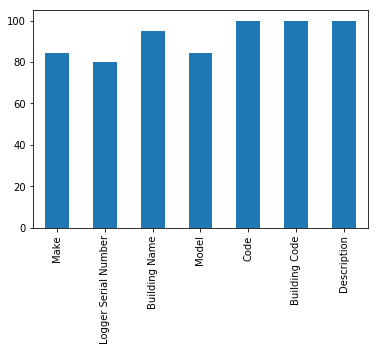

In [100]:
((planon_loggerscontrollers_intersected==master_loggerscontrollers_for_validation_intersected).sum()/\
len(planon_loggerscontrollers_intersected)*100).plot(kind='bar')

Loggers not matching on `Building Name`.

In [101]:
sum(planon_loggerscontrollers_intersected['Building Name']!=master_loggerscontrollers_for_validation_intersected['Building Name'])

18

In [102]:
planon_loggerscontrollers_intersected['Building Name']=[str(s).lower().strip().replace('  ',' ').replace('   ',' ') for s in planon_loggerscontrollers_intersected['Building Name'].values]
master_loggerscontrollers_for_validation_intersected['Building Name']=[str(s).lower().strip().replace('  ',' ').replace('   ',' ') for s in master_loggerscontrollers_for_validation_intersected['Building Name'].values]

In [103]:
sum(planon_loggerscontrollers_intersected['Building Name']!=master_loggerscontrollers_for_validation_intersected['Building Name'])

16

That didnt help.

In [104]:
for i in planon_loggerscontrollers_intersected[planon_loggerscontrollers_intersected['Building Name']!=master_loggerscontrollers_for_validation_intersected['Building Name']].index:
    print(i,'\t\tPlanon:',planon_loggerscontrollers_intersected.loc[i]['Building Name'],'\t\tMaster:',master_loggerscontrollers_for_validation_intersected.loc[i]['Building Name'])

EX001-B01 		Planon: roads - main campus 		Master: underpass
MC029-B01 		Planon: cetad 		Master: bowland hall cetad
MC033-L03 		Planon: county john creed 		Master: john creed
MC047-B02 		Planon: welcome centre 		Master: conference centre
MC047-L01 		Planon: welcome centre 		Master: conference centre
MC047-L02 		Planon: welcome centre 		Master: conference centre
MC055-B01 		Planon: furness residences 		Master: furness blocks
MC071-B01 		Planon: furness college 		Master: furness
MC072-B02 		Planon: psc 		Master: psc building
MC072-B04 		Planon: psc 		Master: psc building
MC103-B01 		Planon: lancaster house hotel 		Master: hotel
MC198-B01 		Planon: grizedale college - offices, bar & social space 		Master: grizedale
MC198-B02 		Planon: grizedale college - offices, bar & social space 		Master: grizedale
OC004-B01 		Planon: chancellor's wharf, wyre house 		Master: chancellors wharf
OC005-B01 		Planon: chancellor's wharf, lune house 		Master: chancellors wharf
OC006-B01 		Planon: chancellor's 

Follow up with lexical distance comparison. That would flag this as a match.

Loggers not matching on `Serial Number`.

In [105]:
sum(planon_loggerscontrollers_intersected['Logger Serial Number']!=master_loggerscontrollers_for_validation_intersected['Logger Serial Number'])

71

In [106]:
planon_loggerscontrollers_intersected['Logger Serial Number']=[str(s).lower().strip().replace('  ',' ').replace('   ',' ').replace('{','').replace('}','') for s in planon_loggerscontrollers_intersected['Logger Serial Number'].values]
master_loggerscontrollers_for_validation_intersected['Logger Serial Number']=[str(s).lower().strip().replace('  ',' ').replace('   ',' ').replace('{','').replace('}','') for s in master_loggerscontrollers_for_validation_intersected['Logger Serial Number'].values]

In [107]:
sum(planon_loggerscontrollers_intersected['Logger Serial Number']!=master_loggerscontrollers_for_validation_intersected['Logger Serial Number'])

9

In [108]:
for i in planon_loggerscontrollers_intersected[planon_loggerscontrollers_intersected['Logger Serial Number']!=master_loggerscontrollers_for_validation_intersected['Logger Serial Number']].index:
    print(i,'\t\tPlanon:',planon_loggerscontrollers_intersected.loc[i]['Logger Serial Number'],'\t\tMaster:',master_loggerscontrollers_for_validation_intersected.loc[i]['Logger Serial Number'])

MC032-L04 		Planon: 50198367 		Master: 050198367e00
MC046-L05 		Planon: 50198895300 		Master: 050198895300
MC063-L01 		Planon: 50198829500 		Master: 050198829500
MC064-L03 		Planon: 50198872600 		Master: 050198872600
MC071-L02 		Planon: 50201286300 		Master: 050201286300
MC071-L05 		Planon: 50201221 		Master: 050201221e00
MC071-L16 		Planon: 50198904000 		Master: 050198904000
MC078-L03 		Planon: 50198864300 		Master: 050198864300
MC102-L01 		Planon: 50157909800 		Master: 050157909800


Technically the same, but there is a number format error. Compare based on float value, if they match, replace one of them. This needs to be amended, as it will throw `cannot onvert to float` exception if strings are left in from the previous step.

In [109]:
z1=[]
z2=[]    
for i in planon_loggerscontrollers_intersected.index:
    if planon_loggerscontrollers_intersected.loc[i]['Logger Serial Number']!=master_loggerscontrollers_for_validation_intersected.loc[i]['Logger Serial Number']:
        if float(planon_loggerscontrollers_intersected.loc[i]['Logger Serial Number'])==\
          float(master_loggerscontrollers_for_validation_intersected.loc[i]['Logger Serial Number']):
                z1.append(str(int(float(planon_loggerscontrollers_intersected.loc[i]['Logger Serial Number']))))
                z2.append(str(int(float(planon_loggerscontrollers_intersected.loc[i]['Logger Serial Number']))))
        else:
            z1.append(planon_loggerscontrollers_intersected.loc[i]['Logger Serial Number'])
            z2.append(master_loggerscontrollers_for_validation_intersected.loc[i]['Logger Serial Number'])
    else:
        z1.append(planon_loggerscontrollers_intersected.loc[i]['Logger Serial Number'])
        z2.append(planon_loggerscontrollers_intersected.loc[i]['Logger Serial Number'])
planon_loggerscontrollers_intersected['Logger Serial Number']=z1
master_loggerscontrollers_for_validation_intersected['Logger Serial Number']=z2

In [110]:
for i in planon_loggerscontrollers_intersected[planon_loggerscontrollers_intersected['Logger Serial Number']!=master_loggerscontrollers_for_validation_intersected['Logger Serial Number']].index:
    print(i,'\t\tPlanon:',planon_loggerscontrollers_intersected.loc[i]['Logger Serial Number'],'\t\tMaster:',master_loggerscontrollers_for_validation_intersected.loc[i]['Logger Serial Number'])

New error percentage:

In [111]:
(planon_loggerscontrollers_intersected!=master_loggerscontrollers_for_validation_intersected).sum()/\
len(planon_loggerscontrollers_intersected)*100

Make                    15.877437
Logger Serial Number     0.000000
Building Name            4.456825
Model                   15.877437
Code                     0.000000
Building Code            0.000000
Description              0.000000
dtype: float64

(Bearing in my mind the above, this is technically 0)

In [112]:
a=np.sort(list(set(planon_meterssensors_filtered.index)))
b=np.sort(list(set(master_meterssensors_for_validation_filtered.index)))
meterssensors_not_in_planon=[]
for i in b:
    if i not in a:
        print(i+',',end=" "),
        meterssensors_not_in_planon.append(i)
print('\n\nMeters in Master, but not in Planon:',
      len(meterssensors_not_in_planon),'/',len(b),':',
      round(len(meterssensors_not_in_planon)/len(b)*100,3),'%')

AP000-L99/M303, AP000-L99/M308, AP080-L79/M001, AP080-L80/M001, AP080-L81/M001, MC000-L99/M201, MC000-L99/M202, MC000-L99/M203, MC000-L99/M506, MC001-L82/M972, MC001-L82/M973, MC001-L82/M974, MC001-L82/M975, MC001-L82/M976, MC001-L99/M100, MC001-L99/M222, MC001-L99/M224, MC001-L99/M306, MC001-L99/M508, MC003-L99/M207, MC003-L99/M304, MC003-L99/M509, MC007-L99/M211, MC007-L99/M511, MC008-L82/M916, MC008-L99/M302, MC010-L82/M745, MC010-L82/M746, MC010-L82/M747, MC010-L82/M748, MC010-L82/M749, MC010-L82/M750, MC010-L82/M751, MC010-L82/M752, MC010-L82/M753, MC010-L82/M754, MC010-L82/M755, MC010-L82/M756, MC010-L82/M757, MC010-L82/M758, MC010-L82/M759, MC010-L82/M760, MC010-L82/M761, MC010-L82/M762, MC010-L82/M763, MC010-L82/M764, MC010-L82/M765, MC010-L82/M766, MC010-L82/M767, MC010-L82/M768, MC010-L82/M769, MC010-L82/M770, MC010-L82/M771, MC010-L82/M772, MC011-L82/M953, MC011-L82/M954, MC032-L82/M773, MC032-L82/M774, MC033-L82/M898, MC033-L82/M899, MC044-L82/M794, MC044-L82/M795, MC044-L8

In [113]:
q1=pd.DataFrame(meterssensors_not_in_planon)

In [114]:
a=np.sort(list(set(planon_meterssensors_filtered.index)))
b=np.sort(list(set(master_meterssensors_for_validation_filtered.index)))
meterssensors_not_in_master=[]
for i in a:
    if i not in b:
        print(i+',',end=" "),
        meterssensors_not_in_master.append(i)
print('\n\nMeters in Planon, not in Master:',
      len(meterssensors_not_in_master),'/',len(a),':',
      round(len(meterssensors_not_in_master)/len(a)*100,3),'%')



Meters in Planon, not in Master: 0 / 28824 : 0.0 %


In [115]:
q2=pd.DataFrame(meterssensors_not_in_master)

In [116]:
a=np.sort(list(set(planon_loggerscontrollers_filtered.index)))
b=np.sort(list(set(master_loggerscontrollers_for_validation_filtered.index)))
loggerscontrollers_not_in_planon=[]
for i in b:
    if i not in a:
        print(i+',',end=" "),
        loggerscontrollers_not_in_planon.append(i)
print('\n\nLoggers in Master, but not in Planon:',
      len(loggerscontrollers_not_in_planon),'/',len(b),':',
      round(len(loggerscontrollers_not_in_planon)/len(b)*100,3),'%')

MC032-L01, MC032-L03, MC044-L02, MC044-L03, MC044-L04, MC044-L05, MC046-L01, MC046-L03, MC046-L04, MC061-L01, MC076-B03, MC202-B17, MC202-L04, MC204-L03, MC204-L04, MC204-L07, MC204-L08, MC204-L09, MC207-L01, 

Loggers in Master, but not in Planon: 19 / 378 : 5.026 %


In [117]:
q3=pd.DataFrame(loggerscontrollers_not_in_planon)

In [118]:
a=np.sort(list(set(planon_loggerscontrollers_filtered.index)))
b=np.sort(list(set(master_loggerscontrollers_for_validation_filtered.index)))
loggerscontrollers_not_in_master=[]
for i in a:
    if i not in b:
        print(i+',',end=" "),
        loggerscontrollers_not_in_master.append(i)
print('\n\nLoggers in Planon, not in Master:',
      len(loggerscontrollers_not_in_master),'/',len(a),':',
      round(len(loggerscontrollers_not_in_master)/len(a)*100,3),'%')



Loggers in Planon, not in Master: 0 / 359 : 0.0 %


In [119]:
q4=pd.DataFrame(loggerscontrollers_not_in_master)

In [120]:
q5=pd.DataFrame((planon_meterssensors_intersected!=master_meterssensors_for_validation_intersected).sum()/\
len(planon_meterssensors_intersected)*100)

In [121]:
q6=pd.DataFrame((planon_loggerscontrollers_intersected!=master_loggerscontrollers_for_validation_intersected).sum()/\
len(planon_loggerscontrollers_intersected)*100)

In [122]:
w1=[]
for i in planon_meterssensors_intersected[planon_meterssensors_intersected['Description']!=master_meterssensors_for_validation_intersected['Description']].index:
    w1.append({"Meter":i,'Planon':planon_meterssensors_intersected.loc[i]['Description'],
               'Master':master_meterssensors_for_validation_intersected.loc[i]['Description']})

In [123]:
q7=pd.DataFrame(w1)

In [124]:
w2=[]
for i in planon_loggerscontrollers_intersected[planon_loggerscontrollers_intersected['Building Name']!=master_loggerscontrollers_for_validation_intersected['Building Name']].index:
    w2.append({"Logger":i,'Planon':planon_loggerscontrollers_intersected.loc[i]['Building Name'],
               'Master':master_loggerscontrollers_for_validation_intersected.loc[i]['Building Name']})

In [125]:
q8=pd.DataFrame(w2)

In [129]:
q9=[]
try:
    for i in q1[0].values:
        if i[:i.find('/')] not in set(q3[0].values):
            q9.append(i)
except:pass

In [130]:
q10=[]
try:
    for i in q1[0].values:
        if 'L82' not in i:
            if 'MC210' not in i:
                q10.append(i)
except:pass

In [134]:
names=['Meters in Master input, but not in the Planon export',
'Meters in the Planon export, but not in Master input',
'Meters in Master input, but not Planon export, but with not missing loggers',
'Meters in Master input, but not Planon export, except which have L82 or MC210 in their code',
'Meters error percentage by data category',
'Meters naming conflcits in the Description field',
'Loggers in Master input, but not in Planon export',
'Loggers in Planon export, but not Master input',
'Loggers error percentage by data category',
'Loggers naming conflcits in the Description field']

In [137]:
writer = pd.ExcelWriter('final6.xlsx')
pd.DataFrame(names).to_excel(writer,'key')
q1.to_excel(writer,'0')
q2.to_excel(writer,'1')
pd.DataFrame(q9).to_excel(writer,'2')
pd.DataFrame(q10).to_excel(writer,'3')
q5.to_excel(writer,'4')
q7.to_excel(writer,'5')
q3.to_excel(writer,'6')
q4.to_excel(writer,'7')
q6.to_excel(writer,'8')
q8.to_excel(writer,'9')
writer.save()